In [82]:
#@title LSTM(Keras)으로 글 분류하기(자연어처리)
#참조 사이트 : https://wikidocs.net/217687

In [83]:
from google.colab import drive
drive.mount('/content/drive')
folder_path='/content/drive/MyDrive/Colab Notebooks/bert_240526_고수의클래스연계/data_folder'
!ls '/content/drive/MyDrive/Colab Notebooks/bert_240526_고수의클래스연계/data_folder'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
corpus2.csv  corpus2_temp.csv  corpus2_test100_answer.csv  corpus2_test100.csv	corpus2_train.csv


In [84]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

In [85]:
import pandas as pd
train = pd.read_csv(folder_path+'/'+'corpus2_train.csv', encoding='UTF-8')
test30 = pd.read_csv(folder_path+'/'+'corpus2_test100_answer.csv', encoding='UTF-8')

In [86]:
display(train.head())
display(test30.head())

,감정,문장
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.


,감정,문장
0,분노,남편과 사별한 후 아무 일도 손에 잡히지 않아. 아이들도 있는데 왜 이러는지 모르겠어.
1,상처,무릎이 아파서 잠시 걷는 것조차 힘들어졌어. 내가 앞으로 무얼 할 수 있을까?
2,불안,먹고 살기 위해 남편이 아직 일하고 있지만 나는 능력이 안 돼서 짜증이 나.
3,당황,실수해서 해고를 당했어. 당장 경제적으로 힘든데 좀 더 잘하지 못해 죄책감이 들어.
4,상처,나이가 들수록 점점 사람 자체를 믿지 못하겠어. 남편도 마찬가지야.


In [87]:
print(train["감정"].groupby([train["감정"]]).count())

감정
기쁨    6126
당황    8731
분노    9132
불안    9303
상처    9122
슬픔    9116
Name: 감정, dtype: int64


In [88]:
# 라벨와 클래스을 매핑 작업
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train['감정'] = encoder.fit_transform(train['감정'])
test30['감정'] = encoder.transform(test30['감정'])
encoder.classes_

array(['기쁨', '당황', '분노', '불안', '상처', '슬픔'], dtype=object)

In [89]:
display(train.head())
display(test30.head())

,감정,문장
0,2,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,2,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2,2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,2,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,2,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.


,감정,문장
0,2,남편과 사별한 후 아무 일도 손에 잡히지 않아. 아이들도 있는데 왜 이러는지 모르겠어.
1,4,무릎이 아파서 잠시 걷는 것조차 힘들어졌어. 내가 앞으로 무얼 할 수 있을까?
2,3,먹고 살기 위해 남편이 아직 일하고 있지만 나는 능력이 안 돼서 짜증이 나.
3,1,실수해서 해고를 당했어. 당장 경제적으로 힘든데 좀 더 잘하지 못해 죄책감이 들어.
4,4,나이가 들수록 점점 사람 자체를 믿지 못하겠어. 남편도 마찬가지야.


In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51530 entries, 0 to 51529
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   감정      51530 non-null  int64 
 1   문장      51530 non-null  object
dtypes: int64(1), object(1)
memory usage: 805.3+ KB


In [91]:
# 문장 열과 감정 열의 중복을 제외한 값의 개수
print(train['문장'].nunique(), train['감정'].nunique())
print(test30['문장'].nunique(), test30['감정'].nunique())

51501 6
100 5


In [92]:
# 문장 열의 중복 제거
train.drop_duplicates(subset=['문장'], inplace=True)
test30.drop_duplicates(subset=['문장'], inplace=True)

In [93]:
print('총 샘플의 수 :',len(train))

총 샘플의 수 : 51501


<Axes: xlabel='감정'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


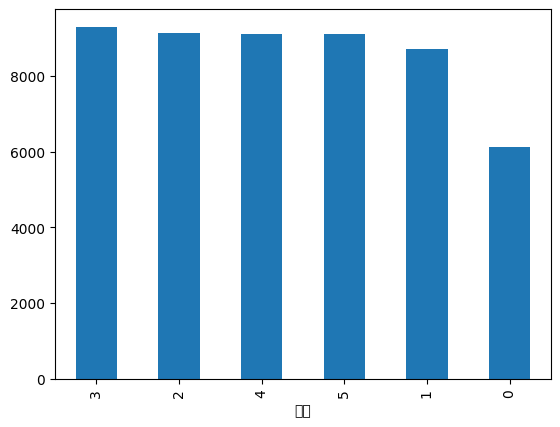

In [94]:
train['감정'].value_counts().plot(kind = 'bar')

In [95]:
train = train.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [96]:
# 한글과 공백을 제외하고 모두 제거
train['문장'] = train['문장'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
display(train[:5])
test30['문장'] = test30['문장'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
test30[:5]

,감정,문장
0,2,일은 왜 해도 해도 끝이 없을까 화가 난다
1,2,이번 달에 또 급여가 깎였어 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나
2,2,회사에 신입이 들어왔는데 말투가 거슬려 그런 애를 매일 봐야 한다고 생각하니까 스트...
3,2,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜 일도 많은 데 정말 분하고 섭섭해
4,2,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나


,감정,문장
0,2,남편과 사별한 후 아무 일도 손에 잡히지 않아 아이들도 있는데 왜 이러는지 모르겠어
1,4,무릎이 아파서 잠시 걷는 것조차 힘들어졌어 내가 앞으로 무얼 할 수 있을까
2,3,먹고 살기 위해 남편이 아직 일하고 있지만 나는 능력이 안 돼서 짜증이 나
3,1,실수해서 해고를 당했어 당장 경제적으로 힘든데 좀 더 잘하지 못해 죄책감이 들어
4,4,나이가 들수록 점점 사람 자체를 믿지 못하겠어 남편도 마찬가지야


In [97]:
train = train.dropna(how = 'any')
print(len(train))

51501


In [98]:
#@title 토큰화
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [99]:
!pip install konlpy

In [100]:
pip install python-mecab-ko

In [101]:
import MeCab

# MeCab 초기화
from mecab import MeCab
mecab = MeCab()

# 분석할 텍스트
text = "안녕하세요, 만나서 반갑습니다."

# 형태소 분석 결과 출력
print(mecab.morphs(text))

['안녕', '하', '세요', ',', '만나', '서', '반갑', '습니다', '.']


In [102]:
!pip install tqdm

In [103]:
from tqdm import tqdm
X_train = []
for sentence in tqdm(train['문장']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 51501/51501 [00:28<00:00, 1809.28it/s]


In [104]:
from tqdm import tqdm
X_test = []
for sentence in tqdm(test30['문장']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 100/100 [00:00<00:00, 3022.03it/s]


In [105]:
print(X_train[:3])

[['일', '왜', '해도', '해도', '끝', '없', '을까', '화', '난다'], ['이번', '달', '또', '급여', '깎였', '어', '물가', '오르', '는데', '월급', '만', '자꾸', '깎이', '니까', '너무', '화', '나'], ['회사', '신입', '들어왔', '는데', '말투', '거슬려', '그런', '애', '매일', '봐야', '한다고', '생각', '니까', '스트레스', '받', '아']]


In [106]:
#@title 4) 학습 데이터, 검증 데이터, 테스트 데이터
y_train = np.array(train['감정'])
y_test = np.array(test30['감정'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [107]:
print(len(y_train))

41200


In [108]:
#@title 5) 단어 집합 만들기
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 12688


In [109]:
print('훈련 데이터에서의 단어 나이의 등장 횟수 :', word_counts['나이'])
print('훈련 데이터에서의 단어 사원의 등장 횟수 :', word_counts['사원'])

훈련 데이터에서의 단어 나이의 등장 횟수 : 1310
훈련 데이터에서의 단어 사원의 등장 횟수 : 86


In [110]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['어', '나', '내', '는데', '너무', '아', '친구', '있', '해', '것']


In [111]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 12688
등장 빈도가 2번 이하인 희귀 단어의 수: 6357
단어 집합에서 희귀 단어의 비율: 50.10245901639344
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.56469540042171


In [112]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 6331


In [113]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [114]:
vocab[:10]

['어', '나', '내', '는데', '너무', '아', '친구', '있', '해', '것']

In [115]:
for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2  #'<PAD>' = 0,'<UNK>' = 1, '어'= 2, '나'=3

In [116]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 6333


In [117]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 맵핑되는 정수 :', word_to_index['친구'])

단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 영화와 맵핑되는 정수 : 8


In [118]:
#@title 6) 정수 인코딩
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [119]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [120]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[1287, 3807, 46, 88, 931]
[141, 10, 537, 11, 14, 5, 1162, 528, 1, 47, 9, 274]


In [121]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [122]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['친정', '조카', '때문', '마음', '쓰여']
복원된 첫번째 샘플 : ['친정', '조카', '때문', '마음', '쓰여']


리뷰의 최대 길이 : 57
리뷰의 평균 길이 : 12.55866504854369


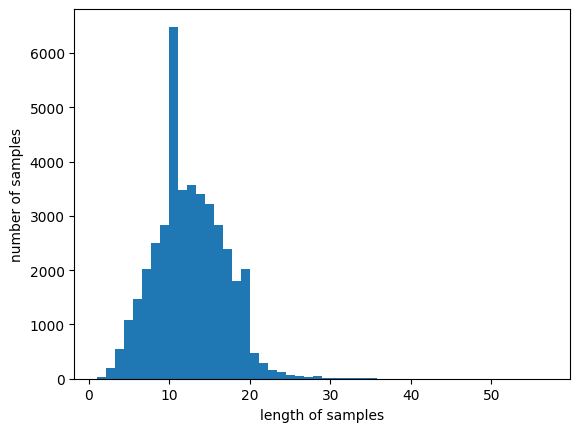

In [123]:
#@title 7)패딩
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [124]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [125]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 99.84223300970874


In [126]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (41200, 30)
검증 데이터의 크기 : (10301, 30)
테스트 데이터의 크기 : (100, 30)


In [127]:
print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

첫번째 샘플의 길이 : 30
첫번째 샘플 : [1287 3807   46   88  931    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [128]:
#@title LSTM을 이용한 감정 분류 모델

In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [130]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cpu


In [135]:
#분류 기준이 2개 이상이면 ohe를 사용하여 분류한다
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train) # one_hot으로 변형
y_valid = to_categorical(y_valid) # one_hot으로 변형
y_test = to_categorical(y_test) # one_hot으로 변형


In [139]:
# Decoding: 각 행에서 가장 큰 값의 인덱스를 구함
y_decoded = np.argmax(y_train[0])
print("Decoded labels:", y_decoded)
y_decoded = np.argmax(y_test, axis=1)
print("Decoded labels:", y_decoded)

Decoded labels: 2
Decoded labels: [2 4 3 1 4 2 5 2 3 1 1 2 1 4 4 2 2 2 1 4 2 4 1 4 2 1 1 1 3 5 1 1 4 1 4 5 2
 5 2 4 1 1 4 2 5 3 1 3 4 1 2 1 4 5 2 3 3 2 2 3 3 4 5 4 1 2 3 1 2 1 2 1 4 3
 4 5 2 2 2 3 4 2 3 1 3 5 1 1 2 3 2 2 2 1 4 2 3 4 3 4]


In [140]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([[0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.]], dtype=torch.float64)


In [142]:
'''
- 단어 벡터의 차원 = 100
- 문장 길이 = 500
- 배치 크기 = 32
- 데이터 개수 = 2만
- LSTM의 은닉층의 크기 = 128
- 분류하고자 하는 카테고리 개수 = 2개
'''
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits

In [141]:
#훈련 데이터, 검증 데이터, 테스트 데이터에 대해서 파이토치 텐서로 변환하고 배치 단위 연산을 위해 데이터로더로 변환합니다.
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [144]:
#훈련 데이터의 샘플 개수가 41200개 였으므로 배치 크기를 32로 할 경우에는 41200/32=3,635 다시 말해 32개씩 묶인 데이터 묶음이 1,288개가 생깁니다. 그리고 학습 시에는 32개씩 데이터가 들어가게 될 것입니다.
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 1288


In [145]:
embedding_dim = 100
hidden_dim = 128
output_dim = 6   #2
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

TextClassifier(
  (embedding): Embedding(6333, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [146]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [155]:
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
     # labels가 one-hot encoded 되어 있으므로 정수형 레이블로 변환
    labels = torch.argmax(labels, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [148]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

In [157]:
#@title 4. 학습
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        #print(batch_y)
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)
        #print(logits.shape)
        #print(batch_y.shape)
        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/5:
Train Loss: 1.7834, Train Accuracy: 0.1796
Validation Loss: 1.7830, Validation Accuracy: 0.1806
Validation loss improved from inf to 1.7830. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 1.7815, Train Accuracy: 0.1785
Validation Loss: 1.7471, Validation Accuracy: 0.2322
Validation loss improved from 1.7830 to 1.7471. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 1.6331, Train Accuracy: 0.2715
Validation Loss: 1.5486, Validation Accuracy: 0.3449
Validation loss improved from 1.7471 to 1.5486. 체크포인트를 저장합니다.
Epoch 4/5:
Train Loss: 1.3759, Train Accuracy: 0.4407
Validation Loss: 1.3454, Validation Accuracy: 0.4866
Validation loss improved from 1.5486 to 1.3454. 체크포인트를 저장합니다.
Epoch 5/5:
Train Loss: 1.1956, Train Accuracy: 0.5424
Validation Loss: 1.2842, Validation Accuracy: 0.5144
Validation loss improved from 1.3454 to 1.2842. 체크포인트를 저장합니다.


In [158]:
#@5. 모델 로드 및 평가
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

<ipython-input-158-70b3a66c00b8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_checkpoint.pth'))


Best model validation loss: 1.2842
Best model validation accuracy: 0.5144


In [159]:
# 테스트 데이터에 대한 정확도와 손실 계산  :: 사실 이건 필요없고.
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 1.5715
Best model test accuracy: 0.3100


In [160]:
print(encoder.classes_)
encoder.classes_[2]

['기쁨' '당황' '분노' '불안' '상처' '슬픔']


'분노'

In [161]:
#@title 6. 모델 테스트
#index_to_tag = {0 : '부정', 1 : '긍정'}
index_to_tag = encoder.classes_

def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    tokens = mecab.morphs(text) # 토큰화
    tokens = [word for word in tokens if not word in stopwords] # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    # Convert tokens to tensor
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

In [162]:
test_input = "이 영화 개꿀잼 ㅋㅋㅋ"
predict(test_input, model, word_to_index, index_to_tag)

'기쁨'